# GRT Final Routines

This is the final development notebook of the GRT project.  In this notebook converge all the lessons learned during development.

In [128]:
from gravray import *
from gravray.util import *
from gravray.stats import *
from gravray.spice import *
from gravray.plot import *
from gravray.sampling import *
from gravray.orbit import *

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
%matplotlib nbagg

## Initialize

In [5]:
dt=elTime(0)
Spice.loadKernels()
cneos=pd.read_csv("data/cneos_fireball_data_location.csv")
cneos.set_index("Name",inplace=True)

<IPython.core.display.Javascript object>


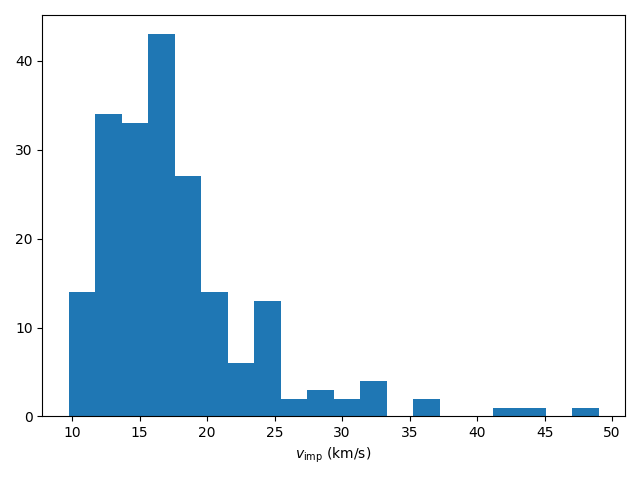

In [15]:
cond=cneos["vimp"]<0
fig,ax=plt.subplots(1,1)
ax.hist(-cneos[cond]["vimp"],20)

ax.set_xlabel(r"$v_{\rm imp}$ (km/s)")
fig.tight_layout()

## Global definitions

In [16]:
body="EARTH"
earth=Body(body)

## Routine definitions

In [17]:
def probRdir(Rdir,site=None,tdb=0,population=None,verbose=False):
    """
    Compute the resulting impact probability at a given site and 
    time and with objects coming from a given population.
    
    Parameters:
        
        Rdir: impact vector (azimuth, elevation and speed), numpy array (3), (rad, rad, m/s)
        
    Optional parameters:
        
        site: Location, location object
        population: Population distribution, MultiVariate object.
        
    Return:
        
        pimp: Impact probability, p(R_i) = p(E_h) |det JER|.
    """
    n=Rdir.shape[1]
    p=np.zeros(n)
    for i in range(n):
        A,h,v=Rdir[:,i]
        ray=GrtRay(location,A,h,v)
        ray.updateRay(tdb)
        try:
            ray.propagateRay(tdb)
            ray.terminal.elements[3:]=np.mod(ray.terminal.elements[3:],2*np.pi)
            if verbose:
                ray.terminal.calcUelements([Const.aphelion,1,np.pi,2*np.pi,2*np.pi,2*np.pi])
                locelements=ray.terminal.uelements
                print(f"Impact conditions: np.array([[{A}],[{h}],[{v}]])")
                print(f"Terminal elements:",
                      Util.transformElements(ray.terminal.elements,[1/Const.au,Angle.Rad]))
                print("Unbound terminal elements:",locelements)

            #Check if orbit is bound
            if ray.terminal.elements[1]<1:
                #J = |dEhel/dRimp| = |dchel/dRimp| x |dehel/dchel| x |dEhel/dehel| 
                detJ=ray.calcJacobianDeterminant()*\
                     (1-ray.terminal.elements[1])*\
                     Jacobians.calcDetMapJacobian(ray.terminal.elements,
                                                  [Const.aphelion,1,np.pi,2*np.pi,2*np.pi,2*np.pi])[0]
                ray.terminal.calcUelements(maxvalues=[Const.aphelion,1,np.pi,2*np.pi,2*np.pi,2*np.pi])
                x=ray.terminal.uelements[:5]
                ph=population.pdf(x)
            #If orbit is not bound probability is null
            else:
                ph=0
                detJ=0
        except AssertionError as e:
            detJ=0
            ph=0
        del ray
        p[i]=ph*np.abs(detJ)
    return p

In [110]:
def probSingleDir(Rdir,site=None,tdb=0,population=None,verbose=False):
    """
    Compute the resulting impact probability at a given site and 
    time and with objects coming from a given population.
    
    Parameters:
        
        Rdir: impact vector (azimuth, elevation and speed), numpy array (3), (rad, rad, m/s)
        
    Optional parameters:
        
        site: Location, location object
        population: Population distribution, MultiVariate object.
        
    Return:
        
        pimp: Impact probability, p(R_i) = p(E_h) |det JER|.
    """
    A,h,v=Rdir
    ray=GrtRay(site,A,h,v)
    ray.updateRay(tdb)
    try:
        ray.propagateRay(tdb)
        ray.terminal.elements[3:]=np.mod(ray.terminal.elements[3:],2*np.pi)
        if verbose:
            print(f"Impact conditions: np.array([[{A}],[{h}],[{v}]])")
            print(f"Terminal elements:",
                  Util.transformElements(ray.terminal.elements,[1/Const.au,Angle.Rad]))
            try:
                ray.terminal.calcUelements([Const.aphelion,1,np.pi,2*np.pi,2*np.pi,2*np.pi])
                locelements=ray.terminal.uelements
                print("Unbound terminal elements:",locelements)
            except:
                print("Hyperbolic orbit")

        #Check if orbit is bound
        if ray.terminal.elements[1]<1:
            #J = |dEhel/dRimp| = |dchel/dRimp| x |dehel/dchel| x |dEhel/dehel| 
            detJ=ray.calcJacobianDeterminant()*\
                 (1-ray.terminal.elements[1])*\
                 Jacobians.calcDetMapJacobian(ray.terminal.elements,
                                              [Const.aphelion,1,np.pi,2*np.pi,2*np.pi,2*np.pi])[0]
            ray.terminal.calcUelements(maxvalues=[Const.aphelion,1,np.pi,2*np.pi,2*np.pi,2*np.pi])
            x=ray.terminal.uelements[:5]
            ph=population.pdf(x)
        #If orbit is not bound probability is null
        else:
            ph=0
            detJ=0
    except AssertionError as e:
        print("Error in ray:",e)
        detJ=0
        ph=0
    del ray
    return ph*np.abs(detJ)

In [111]:
def probImp(Rimp,body=None,tdb=0,population=None,verbose=False):
    """
    Compute the resulting impact probability for a given impact vector, 
    time and with objects coming from a given population.
    
    Parameters:
        
        Rimp: impact matrix (longitude, latitude, height, azimuth, elevation, speed), 
              ie. rows are properties and columns are different values of properties.
              numpy array (6xN), (rad, rad, m, rad, rad, m/s) x N
        
    Optional parameters:
        
        body: body from where the rays are propagated.
        tdb: ephemeris time, float, seconds.
        population: Population distribution, MultiVariate object.
        
    Return:
        
        p: Impact probability p(R_i) = p(E_h) |det JER|, numpy array (N)
    """
    N=Rimp.shape[1]
    p=np.zeros(N)
    for i in range(N):
        lon,lat,alt=Rimp[:3,i]
        Rdir=Rimp[3:,i]
        if verbose:
            print(f"Location: lon = {lon*Angle.Rad}, lat = {lat*Angle.Rad}, alt = {alt/Const.km}")
            print(f"Direction: A = {Rdir[0]*Angle.Rad}, h = {Rdir[1]*Angle.Rad}, v = {Rdir[2]/Const.km}")
        loc=Location(body,lon,lat,alt)
        p[i]=probSingleDir(Rdir,site=loc,tdb=tdb,population=population,verbose=verbose)
        del loc
    return p

## Example conditions

In [112]:
#Site 
lon=59.8703**Angle.Deg #rad
lat=55.0958*Angle.Deg #rad
alt=23.3*Const.km #m

#Time
datestring="02/15/2013 03:20:34"
fmt="%m/%d/%Y %H:%M:%S"
t=Spice.str2tdb(datestring)

#Population
weights=[0.6]
locs=[
    [0.5,0.5,-2.0],
    [2.0,0.3,-2.6]
]
scales=[
    [1.3,0.7,0.5],
    [0.4,0.9,1.6]
]
angles=[
    [-40.0*Angle.Deg,-86.0*Angle.Deg,0.0*Angle.Deg],
    [+80.0*Angle.Deg,-109.0*Angle.Deg,0.0*Angle.Deg]
]
ranges=[
    [Util.fin2Inf(1e-2,360.0),Util.fin2Inf(360.0-1e-2,360.0)],
    [Util.fin2Inf(1e-2,360.0),Util.fin2Inf(360.0-1e-2,360.0)]
]
NEOs=MultiVariate([1,1,1,0,0])
NEOs.setUnflatten(weights,locs,scales,angles,ranges)

#Direction
#"""
Aloc=103.5*Angle.Deg
hloc=18.55*Angle.Deg
vimp=-18.6*Const.km/Const.s
#"""
"""
Aloc=270.*Angle.Deg
hloc=20.*Angle.Deg
vimp=-18.6*Const.km/Const.s
#"""

Rdir=np.array([[Aloc],[hloc],[vimp]])

#Input conditions
print(f"Impact conditions:")
print(f"\tDate: {datestring}")
print(f"\tlon. {lon*Angle.Rad:.4g}, lat. {lat*Angle.Rad:.4g}, alt. {alt/Const.km:.4g} km")
print(f"\tAloc = {Aloc*Angle.Rad:.4g}, hloc = {lat*Angle.Rad:.4g}, vimp = {vimp/Const.km} km/s")

Impact conditions:
	Date: 02/15/2013 03:20:34
	lon. 61.54, lat. 55.1, alt. 23.3 km
	Aloc = 103.5, hloc = 55.1, vimp = -18.6 km/s


## Test routines

In [125]:
location=Location(earth,lon,lat,alt)
probSingleDir([Aloc,hloc,vimp],site=location,tdb=t,population=NEOs,verbose=True)

Impact conditions: np.array([[1.806415775814131],[0.32375857624494814],[-18600.0]])
Terminal elements: [  0.72231578   0.5297087    5.18079402 326.57568287 103.0150748
  24.56944643]
Unbound terminal elements: [ 0.89757661  0.11897496 -3.518794    2.27937803 -0.91414209 -2.61391129]


5.228572267234881e-26

In [114]:
probRdir(np.array([[Aloc],[hloc],[vimp]]),site=location,tdb=t,population=NEOs,verbose=True)

Impact conditions: np.array([[1.806415775814131],[0.32375857624494814],[-18600.0]])
Terminal elements: [  0.70833064   0.52217931   1.63385347 326.53486704 100.21567564
  26.57816191]
Unbound terminal elements: [ 0.83161272  0.08877549 -4.69289712  2.27803264 -0.95252715 -2.52931857]


array([6.97092256e-26])

In [121]:
probImp(np.array([[lon],[lat],[alt],[Aloc],[hloc],[vimp]]),body=earth,tdb=t,population=NEOs,verbose=True)

Location: lon = 61.537638105133716, lat = 55.0958, alt = 23.3
Direction: A = 103.5, h = 18.55, v = -18.6
Impact conditions: np.array([[1.806415775814131],[0.32375857624494814],[-18600.0]])
Terminal elements: [  0.72231578   0.5297087    5.18079402 326.57568287 103.0150748
  24.56944643]
Unbound terminal elements: [ 0.89757661  0.11897496 -3.518794    2.27937803 -0.91414209 -2.61391129]


array([5.22857227e-26])

In [118]:
%timeit -n 100 probSingleDir([Aloc,hloc,vimp],site=location,tdb=t,population=NEOs,verbose=False)
%timeit -n 100 probRdir(np.array([[Aloc],[hloc],[vimp]]),site=location,tdb=t,population=NEOs,verbose=False)
%timeit -n 100 probImp(np.array([[lon],[lat],[alt],[Aloc],[hloc],[vimp]]),body=earth,tdb=t,population=NEOs,verbose=False)

100 loops, best of 3: 28.5 ms per loop
100 loops, best of 3: 26.1 ms per loop
100 loops, best of 3: 26.6 ms per loop


## Multiple integral test

In [129]:
#Site 
lon=59.8703**Angle.Deg #rad
lat=55.0958*Angle.Deg #rad
alt=23.3*Const.km #m

#Time
datestring="02/15/2013 03:20:34"
fmt="%m/%d/%Y %H:%M:%S"
t=Spice.str2tdb(datestring)

#Population
weights=[0.6]
locs=[
    [0.5,0.5,-2.0],
    [2.0,0.3,-2.6]
]
scales=[
    [1.3,0.7,0.5],
    [0.4,0.9,1.6]
]
angles=[
    [-40.0*Angle.Deg,-86.0*Angle.Deg,0.0*Angle.Deg],
    [+80.0*Angle.Deg,-109.0*Angle.Deg,0.0*Angle.Deg]
]
ranges=[
    [Util.fin2Inf(1e-2,360.0),Util.fin2Inf(360.0-1e-2,360.0)],
    [Util.fin2Inf(1e-2,360.0),Util.fin2Inf(360.0-1e-2,360.0)]
]
NEOs=MultiVariate([1,1,1,0,0])
NEOs.setUnflatten(weights,locs,scales,angles,ranges)

#Direction
Aloc=103.5*Angle.Deg
hloc=18.55*Angle.Deg
vimp=-18.6*Const.km/Const.s

Rdir=np.array([[Aloc],[hloc],[vimp]])

#Input conditions
print(f"Impact conditions:")
print(f"\tDate: {datestring}")
print(f"\tlon. {lon*Angle.Rad:.4g}, lat. {lat*Angle.Rad:.4g}, alt. {alt/Const.km:.4g} km")
print(f"\tAloc = {Aloc*Angle.Rad:.4g}, hloc = {lat*Angle.Rad:.4g}, vimp = {vimp/Const.km} km/s")

Impact conditions:
	Date: 02/15/2013 03:20:34
	lon. 61.54, lat. 55.1, alt. 23.3 km
	Aloc = 103.5, hloc = 55.1, vimp = -18.6 km/s


In [130]:
prob=GrtProb(t,earth,NEOs,verbose=True)
prob.setLocation(lon,lat,alt)
p=prob.calcPdir([Aloc,hloc,vimp])
p,prob.ph,prob.detJ,prob.Rdir

Impact conditions: np.array([[1.806415775814131],[0.32375857624494814],[-18600.0]])
Terminal elements: [  0.72231578   0.5297087    5.18079402 326.57568287 103.0150748
  24.56944643]
Unbound terminal elements: [ 0.89757661  0.11897496 -3.518794    2.27937803 -0.91414209 -2.61391129]


(5.228572267234881e-26,
 5.586619321805399e-05,
 -9.359098886202953e-22,
 [1.806415775814131, 0.32375857624494814, -18600.0])

In [135]:
prob=GrtProb(t,earth,NEOs,verbose=False)
prob.setLocation(lon,lat,alt)
def f(*X):
    A,h,v=X
    p=prob.calcPdir([A,h,v])
    return p

In [137]:
from scipy import integrate

In [138]:
f(Aloc,hloc,vimp)

5.228572267234881e-26

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


datetime.datetime(2019, 8, 21, 13, 9, 43, 390783)

In [143]:
print(datetime.now())
dt=elTime(0)
i=integrate.nquad(f,[[0,2*np.pi],[0,np.pi/2],np.array([-72.2,-11.1])*Const.km/Const.s],full_output=True)
dt=elTime(1)
print(datetime.now())

2019-08-21 13:13:15.855311


KeyboardInterrupt: 